1. 関数定義

In [5]:
# =========================
# セル1：関数定義
# =========================

import os, re, math
from dataclasses import dataclass
from typing import Dict, Tuple, List, Optional

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

# Qiskit v2
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
# --- Qiskit version compatibility shim ---
_HAS_ESTIMATOR = False
try:
    # 新しめの環境（Terra>=0.46 系など）
    from qiskit.primitives import Estimator  # type: ignore
    _HAS_ESTIMATOR = True
except Exception:
    try:
        # 旧構成で Aer 側に Estimator がある場合
        from qiskit_aer.primitives import Estimator  # type: ignore
        _HAS_ESTIMATOR = True
    except Exception:
        Estimator = None  # フォールバックで Statevector を使う

from qiskit.quantum_info import Statevector  # フォールバック用

# --- Qiskit primitives compatibility (V2 / V1 / Statevector fallback) ---
import inspect
from qiskit.quantum_info import Statevector  # フォールバック用

ESTIMATOR_MODE = "SV"   # default: Statevector fallback
_Estimator = None

try:
    # Terra>=0.46 などの新系（V2相当、(circuit, [obs]) の“タプル形式”でOK）
    from qiskit.primitives import Estimator as _Estimator
    ESTIMATOR_MODE = "V2"
except Exception:
    try:
        # Aer<=0.15 系の旧Estimator（V1、run(circuits, observables) の“個別引数形式”）
        from qiskit_aer.primitives import Estimator as _Estimator
        ESTIMATOR_MODE = "V1"
    except Exception:
        _Estimator = None  # この場合は Statevector による期待値計算へ



# -----------------------------
# データユーティリティ
# -----------------------------

def resolve_data_path() -> str:
    """
    ノートブックと同じディレクトリに置いたCSVを優先する。
    指定: 'QFF2025/Dataset_Simulated_Price_swaption.csv' があればそれを使う。
    どちらも無ければエラー。
    """
    cand = [
        "QFF2025/Dataset_Simulated_Price_swaption.csv",
        "./Dataset_Simulated_Price_swaption.csv",
        "Dataset_Simulated_Price_swaption.csv",
    ]
    for p in cand:
        if os.path.exists(p):
            return p
    raise FileNotFoundError("Dataset_Simulated_Price_swaption.csv が見つかりません。")


def load_swaption_csv(path: str) -> Tuple[pd.DataFrame, pd.Series]:
    """
    CSVの最終列をDate、それ以外を価格列として読み込む。
    戻り値: (prices_df, dates_series)
    """
    df = pd.read_csv(path)
    date_col = df.columns[-1]
    dates = pd.to_datetime(df[date_col], errors='coerce')
    price_cols = df.columns[:-1]
    prices = df[price_cols].apply(pd.to_numeric, errors='coerce')
    if not dates.is_monotonic_increasing:
        sorter = np.argsort(dates.values)
        prices = prices.iloc[sorter].reset_index(drop=True)
        dates = dates.iloc[sorter].reset_index(drop=True)
    return prices, dates


def make_windows_prices(
    prices: pd.DataFrame,
    dates: pd.Series,
    window: int = 6,
    target: str = "price"  # or "return"
) -> Tuple[np.ndarray, np.ndarray, List[str], List[pd.Timestamp]]:
    """
    価格行列(T×M)からスライディング・ウィンドウを作る。
      X: 過去window日×全系列をフラット化
      y: 翌日の全系列の価格（target='price'）またはリターン（'return'）
    """
    P = prices.values  # (T, M)
    T, M = P.shape
    if target not in ["price", "return"]:
        raise ValueError("target must be 'price' or 'return'")
    R = np.diff(P, axis=0)  # (T-1, M)

    X_list, y_list, date_list = [], [], []
    for t in range(window, T - 1):
        X_list.append(P[t - window : t, :].reshape(-1))  # (window*M,)
        if target == "price":
            y_list.append(P[t, :])         # 翌日価格
        else:
            y_list.append(R[t - 1, :])     # 翌日リターン
        date_list.append(dates.iloc[t])

    X = np.vstack(X_list)
    y = np.vstack(y_list)
    series_names = list(prices.columns)
    return X, y, series_names, date_list


def time_series_split(
    X: np.ndarray, y: np.ndarray, dates: List[pd.Timestamp],
    train_ratio: float = 0.7, val_ratio: float = 0.1
) -> Dict[str, Tuple[np.ndarray, np.ndarray, List[pd.Timestamp]]]:
    """
    時系列順に train / val / test を分割。
    """
    N = X.shape[0]
    n_train = int(N * train_ratio)
    n_val   = int(N * val_ratio)
    n_test  = N - n_train - n_val
    assert n_train > 0 and n_test > 0, "分割比が不正です。"

    parts = {
        "train": (X[:n_train], y[:n_train], dates[:n_train]),
        "val":   (X[n_train:n_train+n_val], y[n_train:n_train+n_val], dates[n_train:n_train+n_val]),
        "test":  (X[n_train+n_val:], y[n_train+n_val:], dates[n_train+n_val:])
    }
    return parts


@dataclass
class Transforms:
    X_scaler: StandardScaler
    Y_scaler: StandardScaler
    PCA_X: PCA
    PCA_Y: PCA


def fit_transforms(X_train: np.ndarray, Y_train: np.ndarray, kx: int, ky: int) -> Transforms:
    """
    学習データで標準化＋PCAをfit（リーケージ防止）。
    X→kx次元、Y→ky次元に圧縮。
    """
    X_scaler = StandardScaler().fit(X_train)
    Xs = X_scaler.transform(X_train)
    PCA_X = PCA(n_components=kx).fit(Xs)

    Y_scaler = StandardScaler().fit(Y_train)
    Ys = Y_scaler.transform(Y_train)
    PCA_Y = PCA(n_components=ky).fit(Ys)

    return Transforms(X_scaler=X_scaler, Y_scaler=Y_scaler, PCA_X=PCA_X, PCA_Y=PCA_Y)


def transform_xy(X: np.ndarray, Y: np.ndarray, tr: Transforms) -> Tuple[np.ndarray, np.ndarray]:
    Xs = tr.X_scaler.transform(X)
    Xbar = tr.PCA_X.transform(Xs)
    Ys = tr.Y_scaler.transform(Y)
    Ybar = tr.PCA_Y.transform(Ys)
    return Xbar, Ybar


def inverse_transform_y(Ybar: np.ndarray, tr: Transforms) -> np.ndarray:
    Ys = tr.PCA_Y.inverse_transform(Ybar)
    Y  = tr.Y_scaler.inverse_transform(Ys)
    return Y


# -----------------------------
# 量子モデル（VQA回帰）
# -----------------------------

def build_feature_encoder(n_qubits: int, xvec: np.ndarray) -> QuantumCircuit:
    """
    Ry角度埋め込み（前段にH）。xvecは標準化＆PCA済み想定。
    サンプル毎min-maxを廃止し、固定スケールで角度化（振幅を保持）。
    """
    qc = QuantumCircuit(n_qubits)
    for q in range(n_qubits):
        qc.h(q)
    xv = np.clip(xvec.astype(float), -3.0, 3.0)
    # 固定スケール: [-3,3] -> [-π/2, π/2]
    angles = (math.pi / 6.0) * xv
    for q, a in enumerate(angles):
        qc.ry(a, q)
    return qc


def build_ansatz(n_qubits: int, depth: int, theta: np.ndarray) -> QuantumCircuit:
    """
    (Rx, Rz) + 線形CNOT を depth 回。
    theta の長さは depth*(2*n_qubits)
    """
    qc = QuantumCircuit(n_qubits)
    ptr = 0
    for _ in range(depth):
        for q in range(n_qubits):
            qc.rx(theta[ptr], q); ptr += 1
            qc.rz(theta[ptr], q); ptr += 1
        for q in range(n_qubits-1):
            qc.cx(q, q+1)
    return qc


def make_observables(n_qubits: int, readout_qubits: List[int]) -> List[SparsePauliOp]:
    """
    n_qubits 全体長で Z を配置（他は I）。
    """
    obs = []
    for q in readout_qubits:
        pauli = ['I'] * n_qubits
        pauli[n_qubits - 1 - q] = 'Z'  # Qiskitの文字列順に合わせる（左が高位ビット）
        obs.append(SparsePauliOp.from_list([(''.join(pauli), 1.0)]))
    return obs


class VQARegressor:
    """
    多出力VQA回帰：
      入力: kx（= n_qubits）
      出力: ky（readout_qubits数）Z期待値
      学習: SPSA（圧縮Y空間のMSE最小化）
    """
class VQARegressor:
    def __init__(self, n_qubits: int, ky: int, depth: int = 2, shots: Optional[int] = None, seed: int = 7):
        assert ky <= n_qubits, "ky は n_qubits 以下である必要があります。"
        self.n_qubits = n_qubits
        self.ky = ky
        self.depth = depth
        self.theta = None
        self.shots = shots
        self.seed = seed

        self.readout_qubits = list(range(ky))
        self.obs = make_observables(n_qubits, self.readout_qubits)

        # ← ここがポイント：Aのシムで決まったモードとEstimatorを使う
        self.estimator_mode = ESTIMATOR_MODE
        self.estimator = _Estimator() if _Estimator is not None else None

    def _build_circuit_for_x(self, x: np.ndarray, theta: np.ndarray) -> QuantumCircuit:
        enc = build_feature_encoder(self.n_qubits, x)
        ans = build_ansatz(self.n_qubits, self.depth, theta)
        return enc.compose(ans)

    def predict_batch(self, Xbar: np.ndarray, theta: Optional[np.ndarray] = None) -> np.ndarray:
        theta = theta if theta is not None else self.theta
        outputs = []

        for x in Xbar:
            qc = self._build_circuit_for_x(x, theta)

            if self.estimator is None:
                # --- Statevector fallback ---
                sv = Statevector.from_instruction(qc)
                vals = [float(np.real(sv.expectation_value(o))) for o in self.obs]

            elif self.estimator_mode == "V2":
                # --- Estimator V2: run([(qc, [obs])]) 形式 ---
                res = self.estimator.run([(qc, self.obs)]).result()
                # values の形が実装差で異なることがあるため安全に平坦化
                vals_arr = np.array(res.values, dtype=float)
                if vals_arr.ndim > 1:
                    vals_arr = vals_arr.reshape(-1)
                vals = vals_arr.tolist()

            else:
                # --- Estimator V1 (Aer): run(circuits, observables) 形式 ---
                circuits = [qc] * len(self.obs)
                job = self.estimator.run(circuits, self.obs)
                vals = job.result().values
                vals = np.array(vals, dtype=float).reshape(-1).tolist()

            outputs.append(vals)

        return np.array(outputs)



    def spsa_fit(
        self, Xbar_train: np.ndarray, Ybar_train: np.ndarray,
        Xbar_val: Optional[np.ndarray] = None, Ybar_val: Optional[np.ndarray] = None,
        maxiter: int = 200, a: float = 0.05, c: float = 0.1, alpha: float = 0.602, gamma: float = 0.101,
        batch_size: int = 32, verbose: int = 1, seed: int = 7
    ) -> Dict[str, List[float]]:
        rng = np.random.default_rng(seed)
        dim_theta = self.depth * (2*self.n_qubits)
        self.theta = rng.normal(0.0, 0.1, size=dim_theta)

        def mse_loss(th, xb, yb):
            yhat = self.predict_batch(xb, th)
            return float(np.mean((yhat - yb)**2))

        N = Xbar_train.shape[0]
        hist = {"train_loss": [], "val_loss": []}

        for k in range(1, maxiter+1):
            ak = a / (k ** alpha)
            ck = c / (k ** gamma)

            start = rng.integers(low=0, high=max(1, N - batch_size))
            xb = Xbar_train[start:start+batch_size]
            yb = Ybar_train[start:start+batch_size]

            delta = rng.choice([-1.0, 1.0], size=self.theta.shape)
            th_plus  = self.theta + ck * delta
            th_minus = self.theta - ck * delta

            Lp = mse_loss(th_plus, xb, yb)
            Lm = mse_loss(th_minus, xb, yb)
            gk = (Lp - Lm) / (2.0 * ck) * delta

            self.theta = self.theta - ak * gk

            tr = mse_loss(self.theta, xb, yb)
            hist["train_loss"].append(tr)
            if Xbar_val is not None and Ybar_val is not None and len(Ybar_val) > 0:
                val = mse_loss(self.theta, Xbar_val, Ybar_val)
                hist["val_loss"].append(val)

            if verbose and (k % max(1, (maxiter // 10)) == 0 or k == 1):
                msg = f", val={hist['val_loss'][-1]:.4f}" if hist["val_loss"] else ""
                print(f"[SPSA] iter {k}/{maxiter} - train={tr:.4f}{msg}")

        return hist


# -----------------------------
# ベースライン
# -----------------------------

def naive_last_price(prices: pd.DataFrame, window: int) -> np.ndarray:
    """
    ウィンドウ終端時点(t-1)の最後の価格をそのまま翌日予測に使う。
    """
    P = prices.values
    preds = []
    for t in range(window, P.shape[0]-1):
        preds.append(P[t-1, :])
    return np.vstack(preds)


def naive_rw_return(prices: pd.DataFrame, window: int) -> np.ndarray:
    """
    ランダムウォーク（リーケージなし）:
      次日予測 = ウィンドウ最終日の価格 + ウィンドウ内の直近リターン
                = P[t-1] + (P[t-1] - P[t-2])
      ※ 評価対象日の実績 P[t] は参照しない
    """
    P = prices.values
    preds = []
    for t in range(window, P.shape[0]-1):
        last_price = P[t-1, :]
        prev_price = P[t-2, :]
        last_ret   = last_price - prev_price
        preds.append(last_price + last_ret)
    return np.vstack(preds)


# -----------------------------
# 指標 & PMCS
# -----------------------------

def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean((y_true - y_pred) ** 2))


def qlike(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> float:
    """
    QLIKE(y,f) = mean( y/f - log(y/f) - 1 ), y,f>0 を想定。
    """
    y = np.maximum(y_true, eps)
    f = np.maximum(y_pred, eps)
    r = y / f
    return float(np.mean(r - np.log(r) - 1.0))


def loss_series_mse(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    return np.mean((y_true - y_pred) ** 2, axis=1)


def loss_series_qlike(y_true: np.ndarray, y_pred: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    y = np.maximum(y_true, eps)
    f = np.maximum(y_pred, eps)
    r = y / f
    return np.mean(r - np.log(r) - 1.0, axis=1)


def pmcs_via_bootstrap(
    loss_ts: Dict[str, np.ndarray],
    B: int = 500, block_len: int = 10, seed: int = 123
) -> Dict[str, float]:
    """
    PMCS近似：時系列ブロック・ブートストラップで、平均損失が最小のモデルと
    “同等” (差が≤tol) と判定される頻度をカウント。
    """
    rng = np.random.default_rng(seed)
    models = list(loss_ts.keys())
    T = len(next(iter(loss_ts.values())))
    for v in loss_ts.values():
        if len(v) != T:
            raise ValueError("すべての損失系列は同じ長さである必要があります。")

    def stationary_block_bootstrap_indices(T, block_len):
        p = 1.0 / block_len
        idx = []
        t = rng.integers(low=0, high=T)
        for _ in range(T):
            idx.append(t)
            if rng.random() < p:
                t = rng.integers(low=0, high=T)
            else:
                t = (t + 1) % T
        return np.array(idx, dtype=int)

    counts = {m: 0 for m in models}
    for _ in range(B):
        idx = stationary_block_bootstrap_indices(T, block_len)
        avg = {m: float(np.mean(loss_ts[m][idx])) for m in models}
        best = min(avg.values())
        tol = 1e-10
        for m in models:
            if avg[m] <= best + tol:
                counts[m] += 1
    return {m: counts[m] / B for m in models}


# -----------------------------
# 可視化
# -----------------------------

def pick_representative_series(y_true: np.ndarray, n_pick: int = 3) -> List[int]:
    var = np.var(y_true, axis=0)
    order = np.argsort(-var)
    return list(order[:n_pick])


def plot_true_vs_pred_timeseries(
    dates: List[pd.Timestamp], y_true: np.ndarray, y_pred: Dict[str, np.ndarray],
    series_names: List[str], indices: Optional[List[int]] = None, save_prefix: Optional[str] = None
):
    if indices is None:
        indices = pick_representative_series(y_true, n_pick=min(3, y_true.shape[1]))
    for idx in indices:
        plt.figure(figsize=(10, 4))
        plt.plot(dates, y_true[:, idx], label="True")
        for name, yp in y_pred.items():
            plt.plot(dates, yp[:, idx], label=name)
        plt.xlabel("Date"); plt.ylabel(series_names[idx])
        plt.title(f"True vs Pred: {series_names[idx]}"); plt.legend()
        plt.tight_layout()
        if save_prefix:
            plt.savefig(f"{save_prefix}_series_{idx}.png", dpi=200)
        plt.show()


def plot_scatter_true_pred(y_true: np.ndarray, y_pred: Dict[str, np.ndarray], save_prefix: Optional[str] = None):
    for name, yp in y_pred.items():
        plt.figure(figsize=(5,5))
        plt.scatter(y_true.flatten(), yp.flatten(), s=8, alpha=0.7)
        mn = min(y_true.min(), yp.min()); mx = max(y_true.max(), yp.max())
        plt.plot([mn, mx], [mn, mx], linestyle='--')
        plt.xlabel("True"); plt.ylabel("Predicted"); plt.title(f"Scatter True vs Pred ({name})")
        plt.tight_layout()
        if save_prefix:
            plt.savefig(f"{save_prefix}_{name}.png", dpi=200)
        plt.show()


def parse_tenor_maturity(col: str) -> Optional[Tuple[str, str]]:
    m = re.search(r"Tenor\s*:\s*([0-9]+)\s*;\s*Maturity\s*:\s*([0-9\.]+)", col)
    return (m.group(1), m.group(2)) if m else None


def plot_rmse_heatmap(y_true: np.ndarray, y_pred: np.ndarray, series_names: List[str], save_path: Optional[str] = None):
    rmse_per_series = np.sqrt(np.mean((y_true - y_pred)**2, axis=0))
    parsed = [parse_tenor_maturity(c) for c in series_names]
    if any(p is None for p in parsed):
        print("[INFO] 列名から Tenor/Maturity を解釈できなかったためヒートマップは省略します。")
        return
    tenors = sorted({p[0] for p in parsed}, key=lambda x: float(x))
    mats   = sorted({p[1] for p in parsed}, key=lambda x: float(x))
    t2i = {t:i for i,t in enumerate(tenors)}; m2i = {m:i for i,m in enumerate(mats)}
    grid = np.full((len(tenors), len(mats)), np.nan)
    for s, name in enumerate(series_names):
        tm = parse_tenor_maturity(name)
        if tm is not None:
            grid[t2i[tm[0]], m2i[tm[1]]] = rmse_per_series[s]
    plt.figure(figsize=(10,6))
    plt.imshow(grid, aspect='auto', origin='lower')
    plt.colorbar(label="RMSE")
    plt.xticks(range(len(mats)), mats, rotation=45, ha='right')
    plt.yticks(range(len(tenors)), tenors)
    plt.xlabel("Maturity"); plt.ylabel("Tenor"); plt.title("RMSE Heatmap by Tenor × Maturity")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=200)
    plt.show()


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


2. 学習

In [6]:
# =========================
# セル2：学習
# =========================

# 設定
# --- セル1未実行でも落ちないように最小ガード ---

import time
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

try:
    resolve_data_path
except NameError:
    import os
    def resolve_data_path():
        for p in ["QFF2025/Dataset_Simulated_Price_swaption.csv",
                  "./Dataset_Simulated_Price_swaption.csv",
                  "Dataset_Simulated_Price_swaption.csv"]:
            if os.path.exists(p):
                return p
        raise FileNotFoundError("Dataset_Simulated_Price_swaption.csv が見つかりません。")


CONFIG = dict(
    csv_path=resolve_data_path(),  # 自動判定
    window=6,
    target="price",        # "return" に変えるとリターン予測→価格再構成に切替可（本コードは価格を直接）
    train_ratio=0.7,
    val_ratio=0.1,
    n_qubits=8,            # X側PCA次元
    ky=4,                  # Y側PCA次元（<= n_qubits）
    depth=2,
    maxiter=150,
    batch_size=32,
    seed=7
)

print("[INFO] CONFIG =", CONFIG)

# 1) 読み込み＆ウィンドウ化
prices, dates = load_swaption_csv(CONFIG["csv_path"])
X, Y, series_names, target_dates = make_windows_prices(
    prices, dates, window=CONFIG["window"], target=CONFIG["target"]
)
parts = time_series_split(X, Y, target_dates, train_ratio=CONFIG["train_ratio"], val_ratio=CONFIG["val_ratio"])
X_tr, Y_tr, d_tr = parts["train"]
X_va, Y_va, d_va = parts["val"]
X_te, Y_te, d_te = parts["test"]

# 2) 変換fit（trainのみ）
tr = fit_transforms(X_tr, Y_tr, kx=CONFIG["n_qubits"], ky=CONFIG["ky"])
Xb_tr, Yb_tr = transform_xy(X_tr, Y_tr, tr)
Xb_va, Yb_va = transform_xy(X_va, Y_va, tr) if len(Y_va) > 0 else (None, None)
Xb_te, Yb_te = transform_xy(X_te, Y_te, tr)

print(f"[ENV] estimator_mode = {getattr(VQARegressor, '__name__', 'VQA')} / "
      f"n_qubits={CONFIG['n_qubits']}, ky={CONFIG['ky']}, depth={CONFIG['depth']}")
print(f"[DATA] prices.shape = {prices.shape}, windows(train/val/test) = "
      f"{X_tr.shape[0]}/{X_va.shape[0]}/{X_te.shape[0]}")
print(f"[PCA]  X cum.var = {tr.PCA_X.explained_variance_ratio_.sum():.3f}, "
      f"Y cum.var = {tr.PCA_Y.explained_variance_ratio_.sum():.3f}")

# 3) VQA学習（SPSA）
vqa = VQARegressor(n_qubits=CONFIG["n_qubits"], ky=CONFIG["ky"], depth=CONFIG["depth"], seed=CONFIG["seed"])
t0 = time.perf_counter()
hist = vqa.spsa_fit(
    Xb_tr, Yb_tr,
    Xb_va, Yb_va,
    maxiter=CONFIG["maxiter"],
    batch_size=CONFIG["batch_size"],
    seed=CONFIG["seed"],
    verbose=1
)

# 4) キャリブレーション（量子出力 -> 圧縮Y の線形合わせ）→ 逆変換で価格へ
Z_tr = vqa.predict_batch(Xb_tr)                  # 量子出力（train, ky次元）
cal  = Ridge(alpha=1e-6, fit_intercept=True).fit(Z_tr, Yb_tr)
print(f"[CAL] compressed-space R2(train) = "
      f"{r2_score(Yb_tr, cal.predict(Z_tr), multioutput='variance_weighted'):.3f}")
Yb_hat_te = cal.predict(vqa.predict_batch(Xb_te))
Y_hat_te  = inverse_transform_y(Yb_hat_te, tr)

# 5) ベースライン
ypred_naive_last = naive_last_price(prices, window=CONFIG["window"])[-len(Y_te):]
ypred_rw_ret     = naive_rw_return(prices, window=CONFIG["window"])[-len(Y_te):]  # (fixed)

# 6) 指標（MSE / QLike）と PMCS
def loss_series_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=1)

def loss_series_qlike(y_true, y_pred, eps: float = 1e-8):
    y = np.maximum(y_true, eps)
    f = np.maximum(y_pred, eps)
    r = y / f
    return np.mean(r - np.log(r) - 1.0, axis=1)

models_pred = {
    "VQA": Y_hat_te,
    "NaiveLast": ypred_naive_last,
    "NaiveRW(fixed)": ypred_rw_ret
}

metrics_tbl = []
for name, yp in models_pred.items():
    m_mse = float(np.mean((Y_te - yp)**2))
    # QLikeは価格>0想定
    eps = 1e-8
    y = np.maximum(Y_te, eps)
    f = np.maximum(yp, eps)
    r = y / f
    m_ql = float(np.mean(r - np.log(r) - 1.0))
    metrics_tbl.append({"Model": name, "MSE": m_mse, "QLike": m_ql})

metrics_df = pd.DataFrame(metrics_tbl)

# PMCS（ブロック・ブートストラップ近似）
loss_mse_ts = {name: loss_series_mse(Y_te, yp) for name, yp in models_pred.items()}
loss_ql_ts  = {name: loss_series_qlike(Y_te, yp) for name, yp in models_pred.items()}

def pmcs_via_bootstrap(loss_ts: Dict[str, np.ndarray], B: int = 400, block_len: int = 10, seed: int = 7) -> Dict[str, float]:
    rng = np.random.default_rng(seed)
    models = list(loss_ts.keys())
    T = len(next(iter(loss_ts.values())))
    def sbb_idx(T, L):
        p = 1.0 / L
        out, t = [], rng.integers(low=0, high=T)
        for _ in range(T):
            out.append(t)
            if rng.random() < p:
                t = rng.integers(low=0, high=T)
            else:
                t = (t + 1) % T
        return np.array(out, dtype=int)
    counts = {m: 0 for m in models}
    for _ in range(B):
        idx = sbb_idx(T, block_len)
        avg = {m: float(np.mean(loss_ts[m][idx])) for m in models}
        best = min(avg.values())
        tol = 1e-10
        for m in models:
            if avg[m] <= best + tol:
                counts[m] += 1
    return {m: counts[m] / B for m in models}

pmcs_mse = pmcs_via_bootstrap(loss_mse_ts, B=400, block_len=10, seed=CONFIG["seed"])
pmcs_ql  = pmcs_via_bootstrap(loss_ql_ts,  B=400, block_len=10, seed=CONFIG["seed"])

metrics_df["Loss of MSE"]     = metrics_df["MSE"]
metrics_df["PMCS of MSE"]     = metrics_df["Model"].map(pmcs_mse)
metrics_df["Loss of QLike"]   = metrics_df["QLike"]
metrics_df["PMCS of QLike"]   = metrics_df["Model"].map(pmcs_ql)

display(metrics_df.style.format({"MSE":"{:.6e}", "QLike":"{:.6e}", "Loss of MSE":"{:.6e}", "Loss of QLike":"{:.6e}",
                                 "PMCS of MSE":"{:.2f}", "PMCS of QLike":"{:.2f}"}))

print("\n[METRICS TABLE]\n" + metrics_df.to_string(index=False))


[INFO] CONFIG = {'csv_path': './Dataset_Simulated_Price_swaption.csv', 'window': 6, 'target': 'price', 'train_ratio': 0.7, 'val_ratio': 0.1, 'n_qubits': 8, 'ky': 4, 'depth': 2, 'maxiter': 150, 'batch_size': 32, 'seed': 7}
[ENV] estimator_mode = VQARegressor / n_qubits=8, ky=4, depth=2
[DATA] prices.shape = (500, 224), windows(train/val/test) = 345/49/99
[PCA]  X cum.var = 0.994, Y cum.var = 1.000


/var/folders/cv/m92t66fj7dv5gcb95qrn8hb40000gn/T/ipykernel_14907/1315993128.py:65: DeprecationWarning: Estimator has been deprecated as of Aer 0.15, please use EstimatorV2 instead.
  vqa = VQARegressor(n_qubits=CONFIG["n_qubits"], ky=CONFIG["ky"], depth=CONFIG["depth"], seed=CONFIG["seed"])
/var/folders/cv/m92t66fj7dv5gcb95qrn8hb40000gn/T/ipykernel_14907/1315993128.py:65: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstimator from qiskit.primitives.
  vqa = VQARegressor(n_qubits=CONFIG["n_qubits"], ky=CONFIG["ky"], depth=CONFIG["depth"], seed=CONFIG["seed"])


[SPSA] iter 1/150 - train=86.2733, val=84.5143
[SPSA] iter 15/150 - train=51.7952, val=79.4723
[SPSA] iter 30/150 - train=13.9764, val=74.1512
[SPSA] iter 45/150 - train=95.2450, val=71.7765
[SPSA] iter 60/150 - train=9.1377, val=70.8162
[SPSA] iter 75/150 - train=46.7742, val=70.0820
[SPSA] iter 90/150 - train=16.3192, val=69.6780
[SPSA] iter 105/150 - train=83.1273, val=69.5341
[SPSA] iter 120/150 - train=12.2444, val=69.1703
[SPSA] iter 135/150 - train=84.5999, val=69.0299
[SPSA] iter 150/150 - train=12.4489, val=68.9705
[CAL] compressed-space R2(train) = 0.604


,Model,MSE,QLike,Loss of MSE,PMCS of MSE,Loss of QLike,PMCS of QLike
0,VQA,1.221953e-04,2.417703e-03,1.221953e-04,0.00,2.417703e-03,0.00
1,NaiveLast,1.282919e-05,1.755246e-04,1.282919e-05,1.00,1.755246e-04,1.00
2,NaiveRW(fixed),2.484104e-05,3.278347e-04,2.484104e-05,0.00,3.278347e-04,0.00



[METRICS TABLE]
         Model      MSE    QLike  Loss of MSE  PMCS of MSE  Loss of QLike  PMCS of QLike
           VQA 0.000122 0.002418     0.000122          0.0       0.002418            0.0
     NaiveLast 0.000013 0.000176     0.000013          1.0       0.000176            1.0
NaiveRW(fixed) 0.000025 0.000328     0.000025          0.0       0.000328            0.0


3. 結果表示

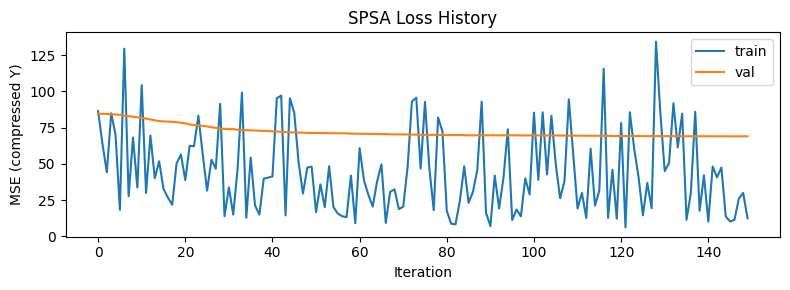

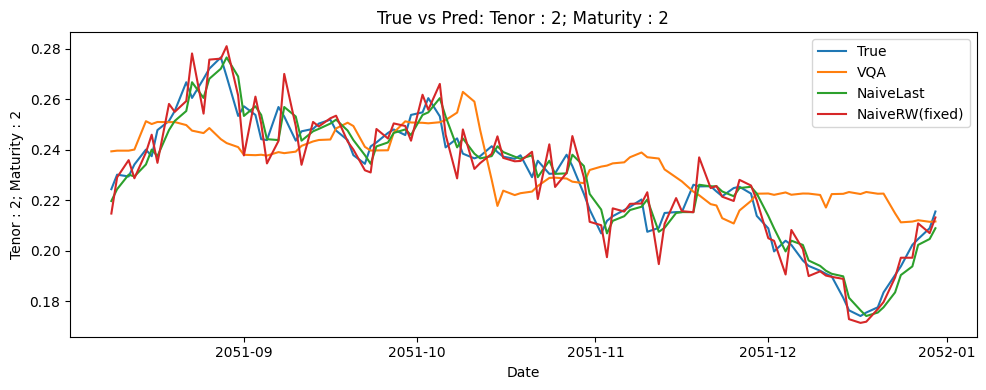

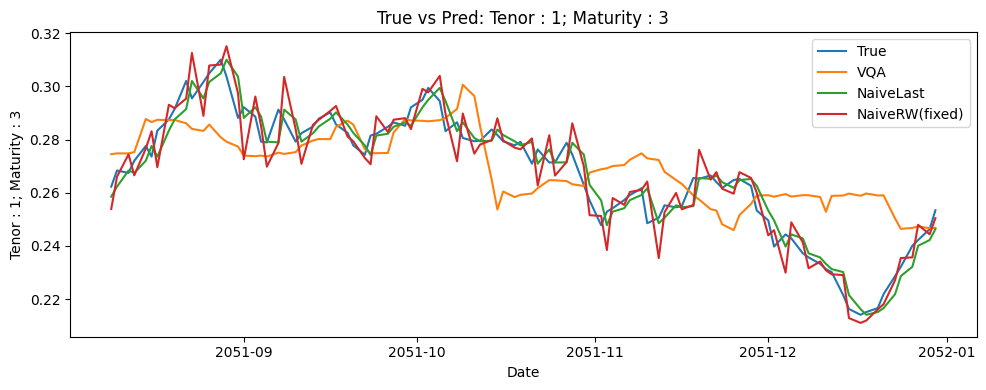

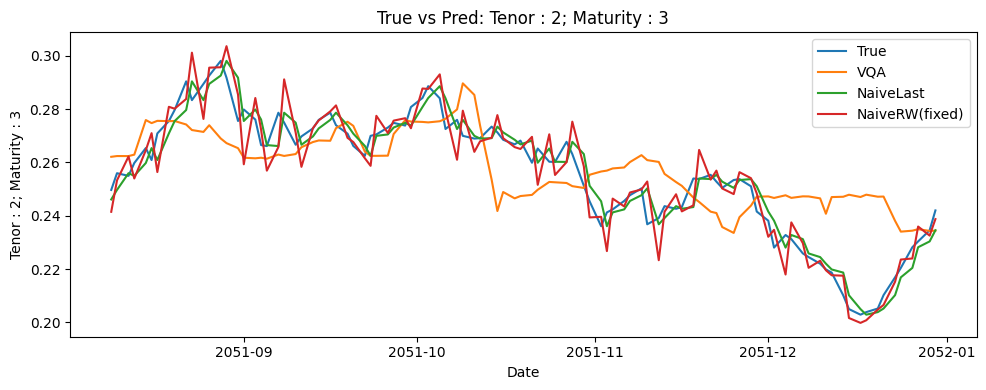

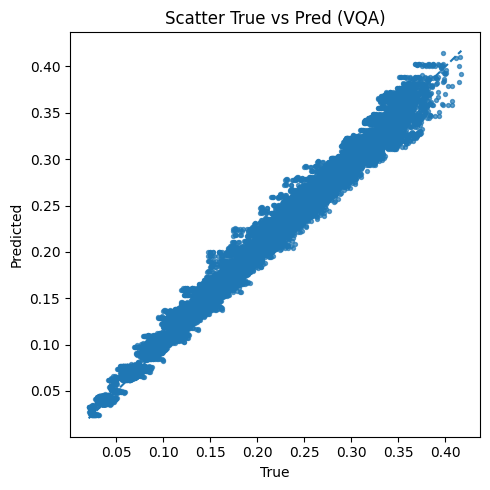

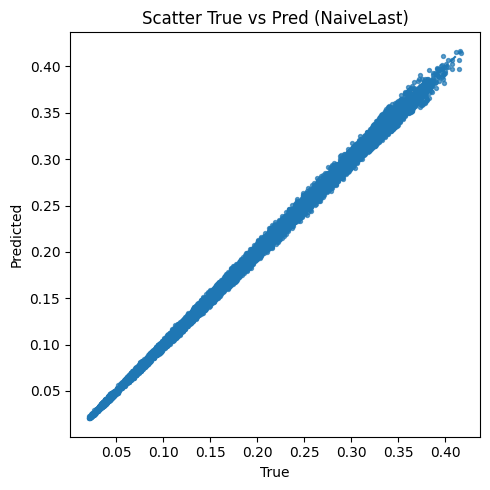

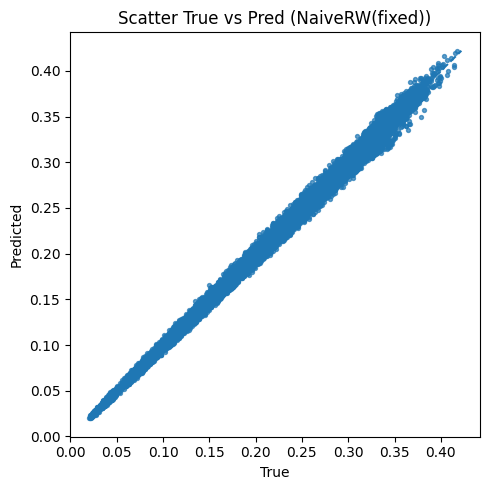

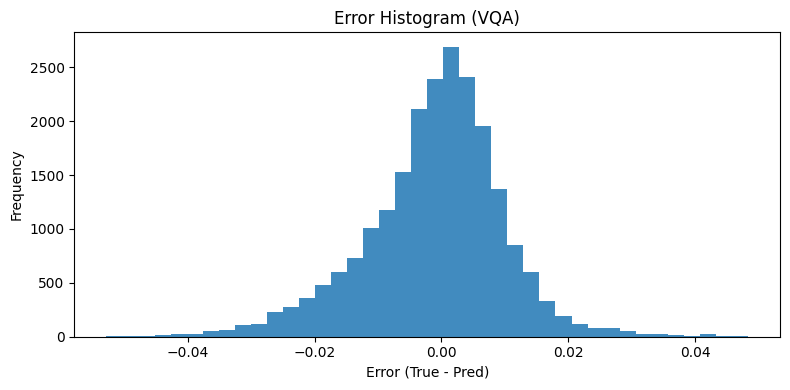

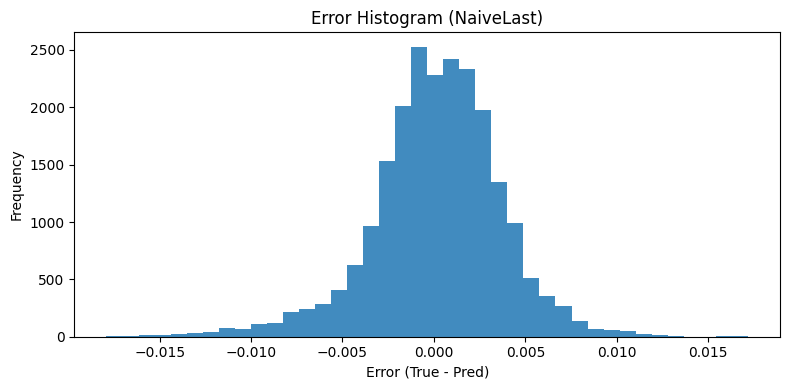

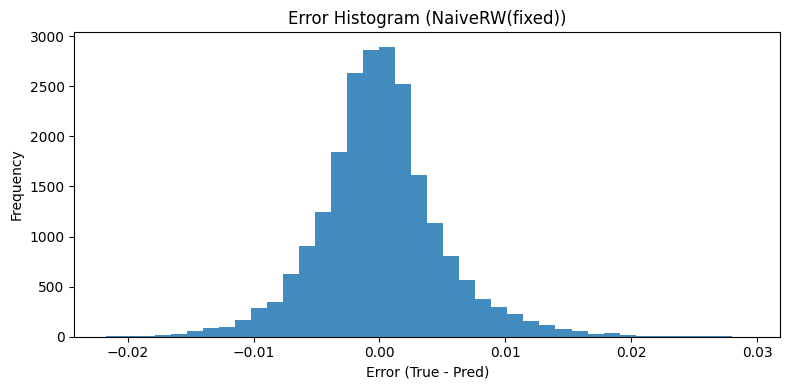

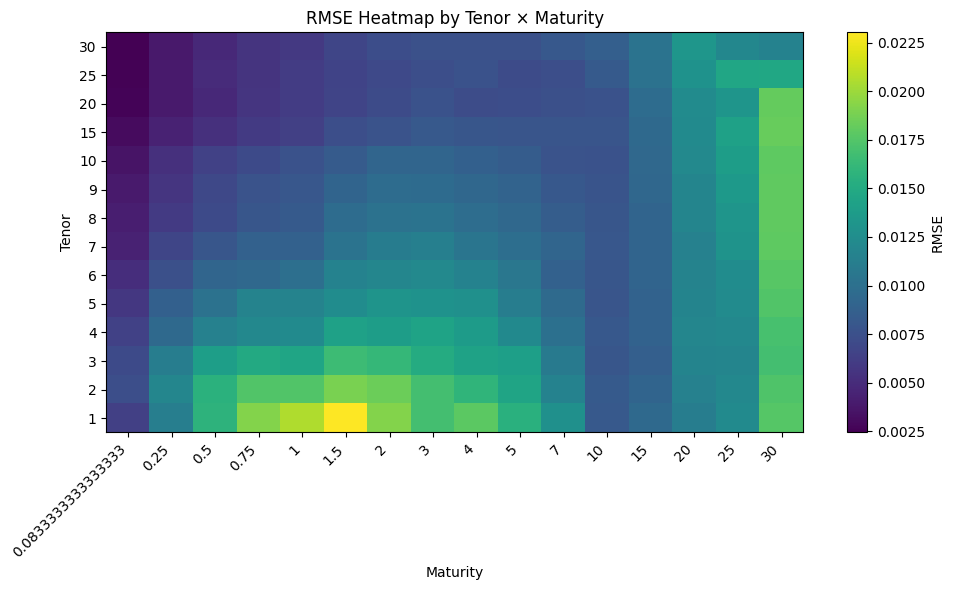

In [7]:
# =========================
# セル3：可視化
# =========================

# 1) 学習曲線（SPSAの圧縮Y空間のMSE）
if "train_loss" in hist and hist["train_loss"]:
    plt.figure(figsize=(8,3))
    plt.plot(hist["train_loss"], label="train")
    if hist.get("val_loss"):
        plt.plot(hist["val_loss"], label="val")
    plt.xlabel("Iteration"); plt.ylabel("MSE (compressed Y)")
    plt.title("SPSA Loss History"); plt.legend()
    plt.tight_layout()
    plt.show()

# 2) True vs Pred（代表系列3本：分散が大きい順に自動抽出）
def pick_representative_series(y_true: np.ndarray, n_pick: int = 3) -> List[int]:
    var = np.var(y_true, axis=0)
    order = np.argsort(-var)
    return list(order[:n_pick])

indices = pick_representative_series(Y_te, n_pick=min(3, Y_te.shape[1]))
for idx in indices:
    plt.figure(figsize=(10,4))
    plt.plot(d_te, Y_te[:, idx], label="True")
    for name, yp in models_pred.items():
        plt.plot(d_te, yp[:, idx], label=name)
    plt.xlabel("Date"); plt.ylabel(series_names[idx])
    plt.title(f"True vs Pred: {series_names[idx]}"); plt.legend()
    plt.tight_layout()
    plt.show()

# 3) 散布図（モデル別）
for name, yp in models_pred.items():
    plt.figure(figsize=(5,5))
    plt.scatter(Y_te.flatten(), yp.flatten(), s=8, alpha=0.7)
    mn = min(Y_te.min(), yp.min()); mx = max(Y_te.max(), yp.max())
    plt.plot([mn, mx], [mn, mx], linestyle='--')
    plt.xlabel("True"); plt.ylabel("Predicted"); plt.title(f"Scatter True vs Pred ({name})")
    plt.tight_layout()
    plt.show()

# 4) 誤差ヒストグラム（モデル別）
for name, yp in models_pred.items():
    err = (Y_te - yp).flatten()
    plt.figure(figsize=(8,4))
    plt.hist(err, bins=40, alpha=0.85)
    plt.xlabel("Error (True - Pred)"); plt.ylabel("Frequency")
    plt.title(f"Error Histogram ({name})")
    plt.tight_layout()
    plt.show()

# 5) Tenor×Maturity RMSEヒートマップ（列名が "Tenor : x; Maturity : y" 形式なら描画）
def parse_tenor_maturity(col: str) -> Optional[Tuple[str, str]]:
    m = re.search(r"Tenor\s*:\s*([0-9]+)\s*;\s*Maturity\s*:\s*([0-9\.]+)", col)
    return (m.group(1), m.group(2)) if m else None

def plot_rmse_heatmap(y_true, y_pred, series_names):
    rmse_per_series = np.sqrt(np.mean((y_true - y_pred)**2, axis=0))
    parsed = [parse_tenor_maturity(c) for c in series_names]
    if any(p is None for p in parsed):
        print("[INFO] 列名から Tenor/Maturity を解釈できなかったためヒートマップは省略します。")
        return
    tenors = sorted({p[0] for p in parsed}, key=lambda x: float(x))
    mats   = sorted({p[1] for p in parsed}, key=lambda x: float(x))
    t2i = {t:i for i,t in enumerate(tenors)}; m2i = {m:i for i,m in enumerate(mats)}
    grid = np.full((len(tenors), len(mats)), np.nan)
    for s, name in enumerate(series_names):
        tm = parse_tenor_maturity(name)
        if tm is not None:
            grid[t2i[tm[0]], m2i[tm[1]]] = rmse_per_series[s]
    plt.figure(figsize=(10,6))
    plt.imshow(grid, aspect='auto', origin='lower')
    plt.colorbar(label="RMSE")
    plt.xticks(range(len(mats)), mats, rotation=45, ha='right')
    plt.yticks(range(len(tenors)), tenors)
    plt.xlabel("Maturity"); plt.ylabel("Tenor"); plt.title("RMSE Heatmap by Tenor × Maturity")
    plt.tight_layout()
    plt.show()

plot_rmse_heatmap(Y_te, models_pred["VQA"], series_names)
